# Evaluate BART-CNN from Huggingface on the dataset CNN
* link1 : https://github.com/dhivyeshrk/FineTuning-Facebook-bart-large-cnn/blob/main/bart-large-cnn-finetune-for-textsummarization.ipynb
* link2 : https://huggingface.co/ainize/bart-base-cnn


In [ ]:
import sys,os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
from datasets import load_dataset
from rouge_score import rouge_scorer

from transformers import AutoTokenizer

In [2]:

NUM_PROCS = os.cpu_count() 
print("NUM_PROCS = " ,NUM_PROCS)

MODEL_HUB = "facebook/bart-large-cnn"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

NUM_PROCS =  12


In [38]:
from transformers import BartTokenizer, BartForConditionalGeneration

# Load Model and Tokenizer
tokenizer = BartTokenizer.from_pretrained(MODEL_HUB, clean_up_tokenization_spaces=True)
model = BartForConditionalGeneration.from_pretrained(MODEL_HUB)


In [39]:
nb_params = 0 
for param in model.parameters():
    if param.requires_grad:
        nb_params += param.numel()

print(f"Total learnable parameters: {nb_params:_}")

memory_in_bytes = nb_params * 4  # 4 octet per parameter (32-bit floats)
#memory_in_gb = memory_in_bytes * 1e-9
param_size_gb = memory_in_bytes / (1024 ** 3)  # Convert bytes to gigabytes

print(f"Model parameters memory usage: {param_size_gb:.2f} GB")

Total learnable parameters: 406_290_432
Model parameters memory usage: 1.51 GB


In [43]:
print(tokenizer.vocab_size)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.bos_token, tokenizer.bos_token_id)
print(tokenizer.eos_token,tokenizer.eos_token_id)
print(tokenizer.unk_token,tokenizer.unk_token_id)
print(tokenizer.model_max_length)
tokenizer

50265
<pad> 1
<s> 0
</s> 2
<unk> 3
1000000000000000019884624838656


BartTokenizer(name_or_path='facebook/bart-large-cnn', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True, special=True),
}

# Load the dataset and analyse some sample 

In [5]:
# Load dataset (e.g., CNN/DailyMail)
dataset = load_dataset("cnn_dailymail", "3.0.0", split='train')


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [37]:
from IPython.display import display, HTML

def sample(dataset,nb_elt=1):
    assert nb_elt <= dataset.__len__()
    idx = np.random.choice(dataset.__len__(),nb_elt,replace=False)
    df_sample = dataset.select(idx).to_pandas().to_html()

    display(HTML(df_sample))


sample(dataset,3)


In [51]:
text =  dataset.select(np.random.choice(dataset.__len__(),1)).to_pandas().article.values[0]
print(text)


print(tokenizer)

print(tokenizer.tokenize(text))

source = tokenizer(text,return_tensors='pt')

print(source["input_ids"].squeeze(),source["attention_mask"].squeeze()) # .squeeze() to keel the batch dim 


By . Sally Lee . and Emily Crane . A woman, 46, has been arrested over the suspicious deaths of two women at their northern NSW nursing home. Marie Darragh, 82 and Isobella Spencer, 77, were found unconscious in their beds on May 10 by staff at St Andrews Village nursing home in Ballina. Police arrested the woman - a nurse at St Andrews Village - at a property in Seaspray, south-east of Melbourne, on Monday morning. She is expected to be charged with the murders as well as the assault of an 88-year-old woman. Scroll down for video . Marie Darragh, 82, was one of two women found unconscious in their beds on May 10 by staff at St Andrews Village nursing home in Ballina . The woman will remain in police custody overnight before appearing in Melbourne Magistrates’ Court on Tuesday. NSW detectives will also apply for the woman to be extradited to Sydney. In June, MailOnline reported that police confirmed they were 'looking at the actions of all nursing home staff' in relation to the deaths 

# Know the length distribution 

In [76]:
def len_distrib(batch):

    len_articles = []
    len_highlights = []
    
    for article, highlight in zip(batch["article"], batch["highlights"]):
        len_articles.append(len(tokenizer(article, truncation=False)["input_ids"]))
        len_highlights.append(len(tokenizer(highlight, truncation=False)["input_ids"]))


    source = tokenizer(batch["article"],truncation=True, max_length=tokenizer.model_max_length)
    resume = tokenizer(batch["highlights"],truncation=True, max_length=tokenizer.model_max_length)

    return {
        'input_ids': source['input_ids'], 
        'input_mask': source['attention_mask'],
        'input_len': len_articles,
        'target_ids': resume['input_ids'], 
        'target_mask': resume['attention_mask'],
        'target_len': len_highlights
        }



batch = dataset.select(np.random.choice(dataset.__len__(),4))
len_distrib(batch)

dataset = dataset.map(len_distrib,num_proc=NUM_PROCS,batched=True,batch_size=32)

Map (num_proc=12):   0%|          | 0/287113 [00:00<?, ? examples/s]

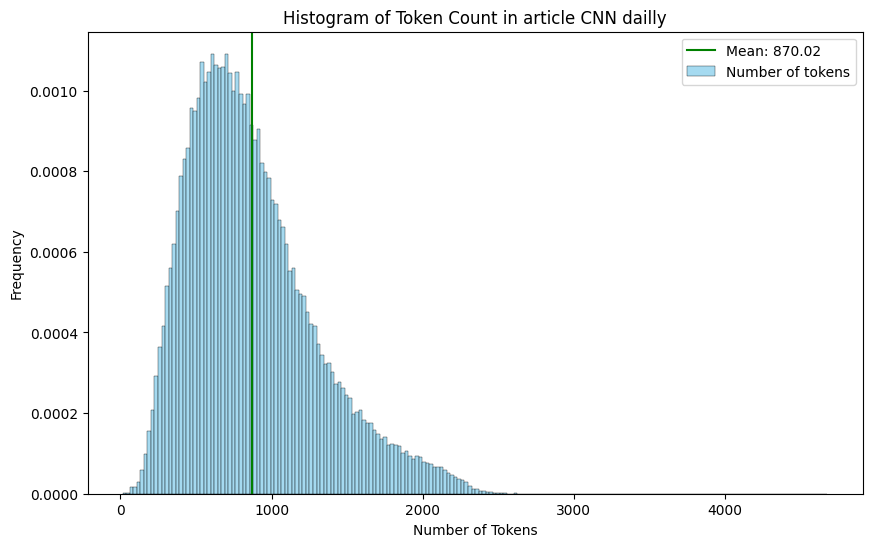

0.00% of texts have more than 1000000000000000019884624838656 tokens
input_len    4677
dtype: int64


In [99]:

# Load input lengths into a DataFrame
article_inputs = pd.DataFrame({"input_len": dataset["input_len"]})

# Create the Seaborn histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=article_inputs, x="input_len", bins=200, kde=False, color='skyblue', label='Number of tokens',stat="density")

# Calculate mean length
mean_length = article_inputs["input_len"].mean()

# Add vertical lines for max token and mean token length
#plt.axvline(x=tokenizer.model_max_length, color='r', linestyle='--', label=f'Max token: {tokenizer.model_max_length}')
plt.axvline(x=mean_length, color='g', linestyle='-', label=f'Mean: {mean_length:.2f}')

# Add title, labels, and legend
plt.title('Histogram of Token Count in article CNN dailly')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()

# Display the plot
plt.show()

# Calculate and display the percentage of texts with more than 512 tokens
percentage_over = (article_inputs[article_inputs["input_len"] > tokenizer.model_max_length].count() / article_inputs.count()) * 100
print(f"{percentage_over['input_len']:.2f}% of texts have more than {tokenizer.model_max_length} tokens")
print(article_inputs.max())

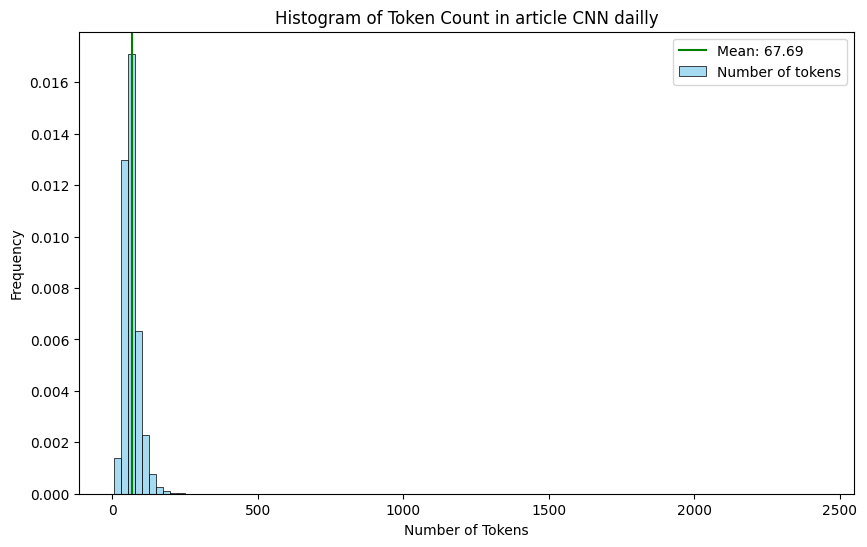

0.00% of texts have more than 1000000000000000019884624838656 tokens
target_len    2428
dtype: int64


In [98]:

# Load input lengths into a DataFrame
target_inputs = pd.DataFrame({"target_len": dataset["target_len"]})

# Create the Seaborn histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=target_inputs, x="target_len", bins=100, kde=False, color='skyblue', label='Number of tokens',stat="density")

# Calculate mean length
mean_length = target_inputs["target_len"].mean()

# Add vertical lines for max token and mean token length
#plt.axvline(x=tokenizer.model_max_length, color='r', linestyle='--', label=f'Max token: {tokenizer.model_max_length}')
plt.axvline(x=mean_length, color='g', linestyle='-', label=f'Mean: {mean_length:.2f}')

# Add title, labels, and legend
plt.title('Histogram of Token Count in article CNN dailly')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()

# Display the plot
plt.show()

# Calculate and display the percentage of texts with more than 512 tokens
percentage_over = (target_inputs[target_inputs["target_len"] > tokenizer.model_max_length].count() / target_inputs.count()) * 100
print(f"{percentage_over['target_len']:.2f}% of texts have more than {tokenizer.model_max_length} tokens")
print(target_inputs.max())